In [1]:
# Analysing initial outputs from Maggie's game
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy as ent
import pyphi
import time
import math

import sys
sys.path.insert(0, '/Users/bjornjuel/projects/actual_agency_fork/')

from pyanimats import *
from actual_agency import *
import pyphi

pyphi.config.VALIDATE_SUBSYSTEM_STATES = False
pyphi.config.PARTITION_TYPE = 'TRI'

%load_ext autoreload
%autoreload 2


Welcome to PyPhi!

If you use PyPhi in your research, please cite the paper:

  Mayner WGP, Marshall W, Albantakis L, Findlay G, Marchman R, Tononi G.
  (2018). PyPhi: A toolbox for integrated information theory.
  PLOS Computational Biology 14(7): e1006343.
  https://doi.org/10.1371/journal.pcbi.1006343

Documentation is available online (or with the built-in `help()` function):
  https://pyphi.readthedocs.io

To report issues, please use the issue tracker on the GitHub repository:
  https://github.com/wmayner/pyphi

For general discussion, you are welcome to join the pyphi-users group:
  https://groups.google.com/forum/#!forum/pyphi-users

To suppress this message, either:
  - Set `WELCOME_OFF: true` in your `pyphi_config.yml` file, or
  - Set the environment variable PYPHI_WELCOME_OFF to any value in your shell:
        export PYPHI_WELCOME_OFF='yes'



In [2]:
# some functions for generating TPM and activity pattern for toy systems
def gen_cm(n_nodes,n_sensors):
    

    # first, indicate the node types (excitatory (+1) or inhibitory (-1))
    node_types = 2*np.random.randint(0,2,size=(n_nodes))-1
    
    # next, produce binary CM to indicate wether or not there is a connection
    connection = np.random.randint(2,size=(n_nodes,n_nodes))
    
    # then, set synaptic weights for individual connections
    w = np.random.rand(n_nodes,n_nodes)
    
    # finally, produce CM
    cm = np.array([[w[i,j]*node_types[j]*connection[i,j] for i in range(n_nodes)] for j in range(n_nodes)])
    cm[:,:2] = 0
    
    cm = np.around(cm,decimals=2)
    
    return cm

def get_states(n_nodes):
    return np.array(([list(('{:0'+str(n_nodes)+'d}').format(int(bin(x)[2:]))) for x in range(2**n_nodes)])).astype(int)

def next_state(cm,activation,state):
    
    node_input = np.matmul(state,cm)
    
    if activation == 'sigmoid':
        p_activation = [sigmoid(i) for i in node_input]
        
    elif activation == 'deterministic':
        p_activation = [1 if i>0 else 0 for i in node_input]
        
    return p_activation


def sample_tpm(cm,activation):
    
    nodes = cm.shape[0]
    next_states = np.zeros((2**nodes,nodes))
    states = get_states(nodes)
    
    for state,row in zip(states,range(2**nodes)):
        next_states[row,:] = next_state(cm,activation,state)
            
    return next_states


def gen_tpm(n_sensors, n_nodes,activation = 'sigmoid'):
    
    total_nodes = n_sensors + n_nodes
    
    # generate a CM
    cm = gen_cm(total_nodes,n_sensors)
    
    # Generates TPM for the agent.
    
    tpm = sample_tpm(cm,'sigmoid')
    
    tpm = pyphi.convert.to_multidimensional(tpm)

    return tpm,cm


def sigmoid(x,slope=1,center=0):
    return 1 / (1 + math.exp(-slope*(x-center)))

def gen_BrainActivity(animat,trials,times,initial_state = None):
    tpm = animat.brain.tpm
    
    if initial_state == None:
        initial_state = np.random.randint(0,2,(trials,animat.n_nodes))
    elif len(initial_state)==animat.n_nodes:
        initial_state = np.matlib.repmat(initial_state,trials,1)
    elif not len(initial_state) == trials:
        print("randomizing intiial states as one was not defined for each trial")
        initial_state = np.random.randint(0,2,(trials,animat.n_nodes))
        
    threshold = np.random.rand(trials,times,animat.n_nodes)
    brain_activity = np.zeros((trials,times,animat.n_nodes))
    
    for trial in range(trials):
        brain_activity[trial,0,:] = initial_state[trial,:]
        for time in range(1,times):
            p_activation = tpm[tuple(brain_activity[trial,time-1,:].astype(int))]
            next_state = [1 if p>t else 0 for p,t in zip(p_activation,threshold[trial,time,:])]
            brain_activity[trial,time,:] = next_state
            
    return brain_activity.astype(int)
    

def save_phi_from_MCs(animat):
    '''

        Inputs:

        Outputs:
    '''

    phis = []
    for s in animat.unique_states:

        if animat.MCs[state2num(s)] == None:
            phis.append(0)
        else:
            phis.append(animat.MCs[state2num(s)].phi)
    animat.phis = phis





In [31]:
# creating an animat
animat = Animat({'hiddenNodes' : 2})
tpm,cm = gen_tpm(4,2)
animat.saveBrain(tpm,np.ceil(np.abs(cm)))

In [32]:
# creating brain activity from TPM
animat.saveBrainActivity(gen_BrainActivity(animat,1,20))


In [65]:
# finding and saving unique states and transitions
animat.saveUniqueTransitions()
animat.saveUniqueStates()

In [66]:
# calculating IIT parameters for all unique states 
pyphi.config.PROGRESS_BARS=False
animat.save_major_complex()

Finding MC for state number 0 out of 19 unique states
Finding MC for state number 1 out of 19 unique states
Finding MC for state number 2 out of 19 unique states
Finding MC for state number 3 out of 19 unique states
Finding MC for state number 4 out of 19 unique states
Finding MC for state number 5 out of 19 unique states
Finding MC for state number 6 out of 19 unique states
Finding MC for state number 7 out of 19 unique states
Finding MC for state number 8 out of 19 unique states
Finding MC for state number 9 out of 19 unique states
Finding MC for state number 10 out of 19 unique states
Finding MC for state number 11 out of 19 unique states
Finding MC for state number 12 out of 19 unique states
Finding MC for state number 13 out of 19 unique states
Finding MC for state number 14 out of 19 unique states
Finding MC for state number 15 out of 19 unique states
Finding MC for state number 16 out of 19 unique states
Finding MC for state number 17 out of 19 unique states
Finding MC for state

In [67]:
# calculating AC parameters for unique transitions
animat.save_unique_causal_links()

Finding causes for transition number 0 out of 19 unique transitions
Finding causes for transition number 1 out of 19 unique transitions
Finding causes for transition number 2 out of 19 unique transitions
Finding causes for transition number 3 out of 19 unique transitions
Finding causes for transition number 4 out of 19 unique transitions
Finding causes for transition number 5 out of 19 unique transitions
Finding causes for transition number 6 out of 19 unique transitions
Finding causes for transition number 7 out of 19 unique transitions
Finding causes for transition number 8 out of 19 unique transitions
Finding causes for transition number 9 out of 19 unique transitions
Finding causes for transition number 10 out of 19 unique transitions
Finding causes for transition number 11 out of 19 unique transitions
Finding causes for transition number 12 out of 19 unique transitions
Finding causes for transition number 13 out of 19 unique transitions
Finding causes for transition number 14 out 

In [68]:
save_phi_from_MCs(animat)

In [69]:
history = history_of_complexes(animat,only_state_changes=False)

In [70]:
MC_cause = get_causal_history(animat, 0,MC=True)

In [71]:
MC_cause

[(0, 2, 3, 4),
 (0, 2, 3, 4),
 (0, 1, 2, 3),
 (0, 2, 3),
 (0, 1, 3, 4),
 (0, 3, 4),
 (0, 1, 2, 3),
 (0, 1, 3, 4),
 (0, 1, 3, 4),
 (0, 1, 2, 3, 4),
 (0, 1, 2, 3),
 (0, 1, 2, 3),
 (0, 1, 3, 4),
 (0, 2, 3, 4),
 (0, 1, 3),
 (0, 1, 3, 4),
 (0, 1, 2, 3, 4),
 (0, 2, 3, 4),
 (0, 2)]

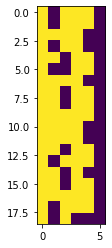

In [72]:

complex_cause_history = [[1 if i in cause else 0 for i in range(animat.n_nodes)] for cause in MC_cause]
plt.imshow(complex_cause_history)

In [74]:
history

[[[0, 0, 0, 1, 1, 0],
  [0, 0, 0, 1, 1, 0],
  [0, 0, 0, 1, 1, 0],
  [0, 0, 0, 1, 1, 0],
  [0, 0, 0, 1, 1, 0],
  [0, 0, 0, 1, 1, 0],
  [0, 0, 0, 1, 1, 0],
  [0, 0, 0, 1, 1, 0],
  [0, 0, 0, 1, 1, 0],
  [0, 0, 0, 1, 1, 0],
  [0, 0, 0, 1, 1, 0],
  [0, 0, 0, 1, 1, 0],
  [0, 0, 0, 1, 1, 0],
  [0, 0, 0, 1, 1, 0],
  [0, 0, 0, 1, 1, 0],
  [0, 0, 0, 1, 1, 0],
  [0, 0, 0, 1, 1, 0],
  [0, 0, 0, 1, 1, 0],
  [0, 0, 0, 1, 1, 0],
  [0, 0, 0, 1, 1, 0]]]

In [58]:
occ = (2,3)
overlaps = [get_complex_purview_overlap(animat,trans,occ) for trans in animat.unique_transitions]

In [59]:
overlaps

[0.6666666666666666,
 0.6666666666666666,
 0.25,
 0,
 0.5,
 0.6666666666666666,
 0.25,
 0.5,
 0.5,
 0.5,
 0.25,
 0.25,
 0.5,
 0.6666666666666666,
 0.25,
 0.5,
 0.5,
 0.6666666666666666,
 0]

In [ ]:
get_union_of_causes(animat,animat.unique_transitions[0],(2,3))

In [ ]:
ba = np.vstack((animat.brain_activity,animat.brain_activity))

In [ ]:
t = animat.unique_transitions[0]

In [ ]:
animat.unique_transitions.index(t)

In [ ]:

with open('animat.pkl', 'wb') as f:
    pickle.dump(animat, f, pickle.HIGHEST_PROTOCOL)

In [ ]:

with open('animat.pkl', 'rb') as f:
    animat = pickle.load(f)

In [75]:
overlaps = [get_complex_purview_overlap(animat,trans,'MC') for trans in animat.unique_transitions] 

In [76]:
overlaps

[0.5,
 0.5,
 0.2,
 0.25,
 0.5,
 0.6666666666666666,
 0.2,
 0.5,
 0.5,
 0.4,
 0.2,
 0.2,
 0.5,
 0.5,
 0.25,
 0.5,
 0.4,
 0.5,
 0.0]

In [ ]:

    EEG(i) = pop_cleanline(EEG(i),'SignalType','Channels')
    EEG(i) = pop_eegfiltnew(EEG(i),0,100)
    EEG(i) = pop_select(EEG(i),'timerange',[1200 1800]);
    
    EEG_FRG(i) = pop_select(EEG(i),'channel',[1:20]);
    EEG_FRG(i) = pop_reref(EEG_FRG(i),length(EEG_FRG),'keepref','on');
    
    EEG_PRG(i) = pop_select(EEG(i),'channel',[21:36]);
    EEG_PRG(i) = pop_reref(EEG_PRG(i),length(EEG_PRG),'keepref','on');
    
    EEG_INFTEMP(i) = pop_select(EEG(i),'channel',[37:42]);
    EEG_INFTEMP(i) = pop_reref(EEG_INFTEMP(i),length(EEG_INFTEMP),'keepref','on');
    
    EEG_SUBTEMP(i) = pop_select(EEG(i),'channel',[43:48]);
    EEG_SUBTEMP(i) = pop_reref(EEG_SUBTEMP(i),length(EEG_SUBTEMP),'keepref','on');
    
    EEG_AMY(i) = pop_select(EEG(i),'channel',[49:56]);
    EEG_AMY(i) = pop_reref(EEG_AMY(i),length(EEG_AMY),'keepref','on');
    
    EEG_HIP(i) = pop_select(EEG(i),'channel',[57:64]);
    EEG_HIP(i) = pop_reref(EEG_HIP(i),length(EEG_HIP),'keepref','on');
    

In [62]:
def num2state2(num,n_nodes):
    '''
    Function description
        Inputs:
            inputs:
        Outputs:
            outputs:
    '''

    number = '{0:0' + str(n_nodes) + 'b}'
    state = number.format(num)
    state = [int(i) for i in state]

    # returns the state
    return state

In [104]:
num2state(9,8)

[1, 0, 0, 1, 0, 0, 0, 0]

In [106]:
state2num(tuple([1, 0, 0, 1, 0, 0, 0, 0]))

9

In [98]:
a.reverse()
print(a)

[1, 0, 0, 0, 0, 0, 0, 0]


In [97]:
# Operating System List
os = ['Windows', 'macOS', 'Linux']
print('Original List:', os)

# List Reverse
os.reverse()

# updated list
print('Updated List:', os)

Original List: ['Windows', 'macOS', 'Linux']
Updated List: ['Linux', 'macOS', 'Windows']
